In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy import spatial
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib.cm as cm
import emcee
import corner
import pdb

1. (a)

In [2]:
import fsps
# assume a constant SFH, Kroupa IMF, solar metallicity
sp = fsps.StellarPopulation(sfh=1, const=1, zcontinuous=1, logzsol=0, tage=13.6)

In [3]:
# calcualte sfr and fuv mag
sfr = sp.sfr
m_fuv = sp.get_mags(tage=13.6, bands=['galex_fuv'])[0]

In [4]:
import astropy.units as u
import astropy.constants as c
# convert mag to flux
f_fuv = 10**(m_fuv/-2.5)*(3631e-23)
L_fuv = f_fuv*4*np.pi*(10*u.pc.to(u.cm))**2
filt = fsps.get_filter('galex_fuv')
vL_fuv = L_fuv * (c.c.to(u.angstrom*u.Hz).value) / filt.lambda_eff 
# calculate C_fuv
C_fuv = np.log10(vL_fuv) - np.log10(sfr)
print('log(C_FUV) = %.2f' %C_fuv)

log(C_FUV) = 43.34


1.(b)

It's almost the same as Kennicutt & Evans (2012) which is 43.35.

2


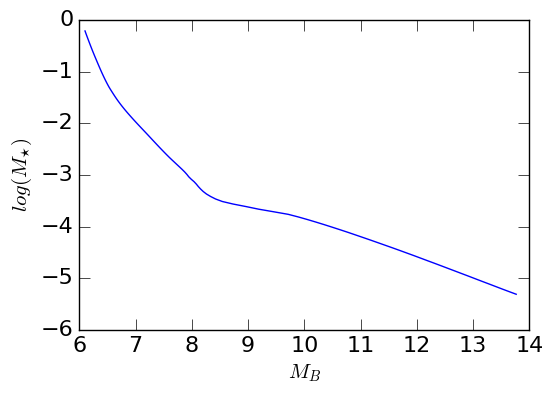

In [5]:
mag_b = sp.get_mags(bands=['b'])
mass = np.log10(sp.stellar_mass)
plt.clf()
plt.plot(mag_b, mass)
plt.xlabel(r'$M_B$')
plt.ylabel(r'$log(M_{\star})$')

B-band is not a great proxy because when Mb is smaller than 8, stellar mass changes a little when Mb changes a lot.

3

In [6]:
t = Table.read('data', format='ascii')
# calculate aboluste B band magnitude
Rv = 3.1
mag_b = np.array(t['B'] - Rv*t['E(B-V)'])
D = np.array(t['Dist'])*10**6
mag_abs_b = mag_b - 5*(np.log10(D) - 1)
# convert to metallicity using Berg et al 2012
metal = 6.27 - 0.11*mag_abs_b 

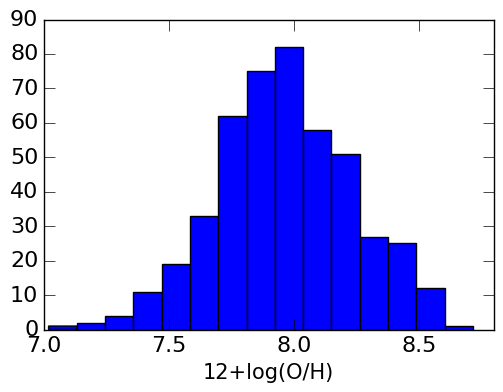

In [7]:
# plot the distribution of metallicity
plt.clf()
plt.hist(metal, bins=15)
plt.xlabel('12+log(O/H)')

4(a)

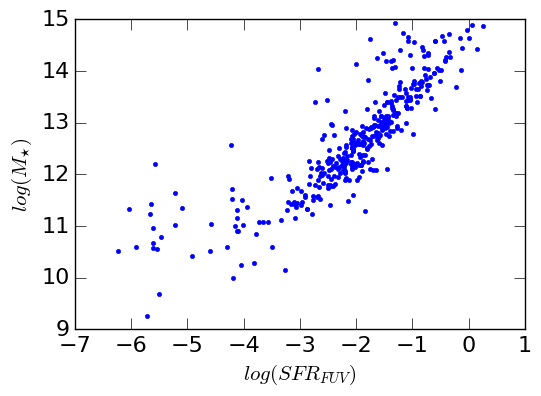

In [8]:
# calculate SRF_fuv
idx = np.where(t['FUV']!=99.99)[0]
m_fuv = np.array(t['FUV'][idx])                   # apparanet mag
M_fuv = m_fuv - 5*(np.log10(D[idx]) - 1)          # absolute mag
f_fuv = 10**(M_fuv/-2.5)*(3631e-23)               # flux
L_fuv = f_fuv*4*np.pi*(10*u.pc.to(u.cm))**2       # luminosity
vL_fuv = L_fuv * (c.c.to(u.angstrom*u.Hz).value) / filt.lambda_eff    # vFv
log_sfr = np.log10(vL_fuv) - 43.35

# calculate Mass using MB
# using problem2, derive stellar mass and Mb at the most recent star formation
mag_b_model = mag_b[-1]
mass_model = 10**mass[-1]
# assume stellar mass and lumonosity are propotional
mass = mass_model * 10**((mag_abs_b[idx]-mag_b_model)/-2.5)

# plot the log_sfr vs log_mss
plt.clf()
plt.plot(log_sfr, np.log10(mass),'.')
plt.xlabel(r'$log(SFR_{FUV})$')
plt.ylabel(r'$log(M_{\star})$')

4(b)

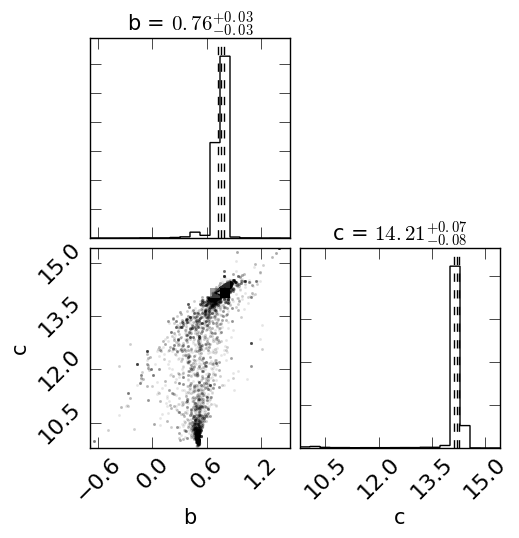

In [17]:
# use a linear function to fit log-log data
# M = sfr*b + c
def ln_prior(theta):
    return 0
def ln_likelihood(theta, sfr, mass):
    b, c = theta
    mass_model = sfr*b + c
    chi2 = np.sum(-(mass-mass_model)**2)
    return chi2
def ln_posterior(theta, sfr, mass):
    return ln_prior(theta) + ln_likelihood(theta, sfr, mass)

# run mcmc to get the best fit quadratic function
steps = 1000
nwalkers = 100
ndim = 2
theta0 = [0.5,10]
pos = [np.random.normal((theta0), (0.01, 0.1)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(log_sfr, np.log10(mass)))
sampler.run_mcmc(pos, steps)
samples = sampler.chain.reshape((-1, ndim))
corner.corner(samples, labels=['b', 'c'], quantiles=[0.16, 0.5, 0.84], show_titles=True)
print('')

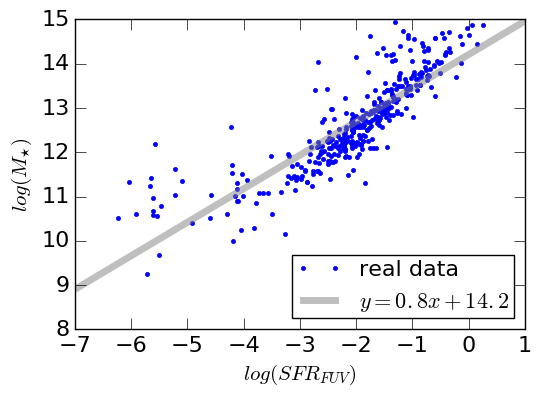

In [18]:
# overplot on the data
b, c = np.median(samples, axis=0)
sfr = np.linspace(-7, 1, 1000)
plt.plot(log_sfr, np.log10(mass), 'b.', label='real data')
plt.plot(sfr, b*sfr+c, color='grey', ls='-', lw=5, label=r'$y=%.1f x + %.1f$' %(b,c), alpha=0.5)
plt.legend(loc='best')
plt.xlabel(r'$log(SFR_{FUV})$')
plt.ylabel(r'$log(M_{\star})$')

4(c)

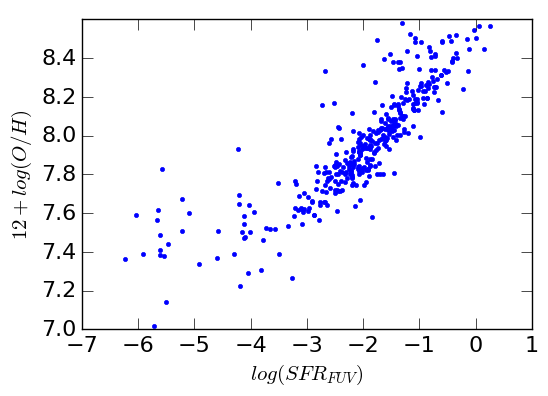

In [19]:
# plot the log_sfr vs metallicity
plt.clf()
metal = metal[idx]
plt.plot(log_sfr, metal,'.')
plt.xlabel(r'$log(SFR_{FUV})$')
plt.ylabel(r'$12+log(O/H)$')

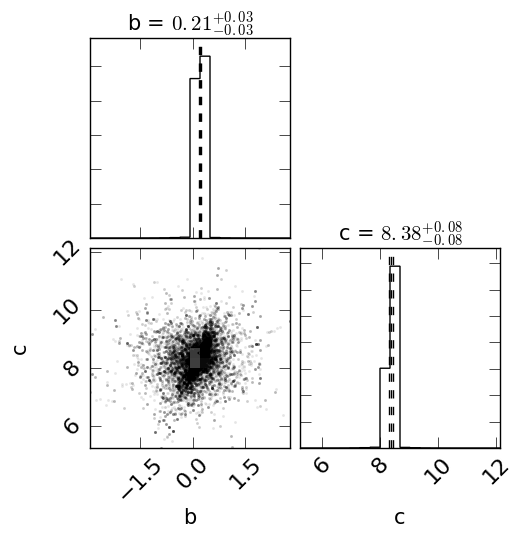

In [21]:
# use a quadratic function to fit log-log data
# M = sfr*a**2 + sfr*b + c
def ln_prior(theta):
    return 0
def ln_likelihood(theta, sfr, metal):
    b, c = theta
    metal_model = sfr*b + c
    chi2 = np.sum(-(metal-metal_model)**2)
    return chi2
def ln_posterior(theta, sfr, metal):
    return ln_prior(theta) + ln_likelihood(theta, sfr, metal)

# run mcmc to get the best fit quadratic function
steps = 1000
nwalkers = 1000
ndim = 2
theta0 = [-0.1,8.3]
pos = [np.random.normal((theta0), (1, 1)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(log_sfr, metal))
sampler.run_mcmc(pos, steps)
samples = sampler.chain.reshape((-1, ndim))
corner.corner(samples, labels=['b', 'c'], quantiles=[0.16, 0.5, 0.84], show_titles=True)
print('')

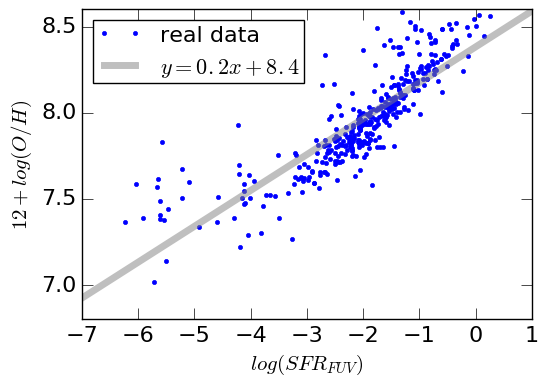

In [24]:
# overplot on the data
b, c = np.median(samples, axis=0)
plt.plot(log_sfr, metal, 'b.', label='real data')
sfr = np.linspace(-7, 1, 1000)
plt.plot(sfr, b*sfr+c, color='grey', ls='-', lw=5, label=r'$y=%.1f x + %.1f$' %(b,c), alpha=0.5)
plt.legend(loc='best')
plt.xlabel(r'$log(SFR_{FUV})$')
plt.ylabel(r'$12+log(O/H)$')


5

When calculating stellar mass, I assume B band magnitude is propotional to stellar mass, but this may not be a good approximation. From FSPS modeling, we get the relationship for B band magnitude and stellar mass for 6<MB<14, it would be very helpful if we can get their relationship, especially for a broader range of B magnitude for very bright galaxy. 

Star formation rate is calculated based on FUV magnitude, it would be better if we have infrad emission and H-alpha flux to calculate SFR too.

Also, at the first step, when I use FSPS, I make an assumption of constant SFH, single metallicity and a universal Kroupa IMF. These parameters may vary with different galaxy morphology.